In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal.signaltools
import pymc as pm
import arviz as az

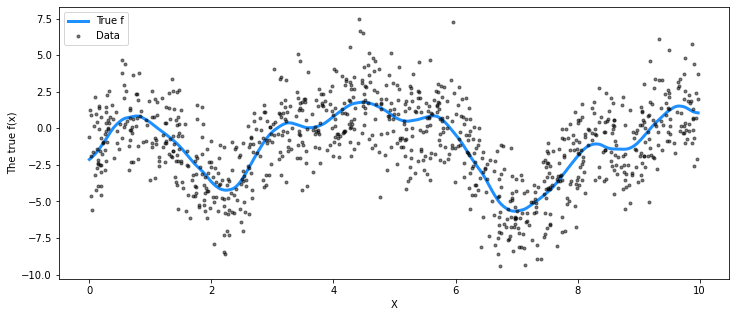

In [2]:
np.random.seed(1)

n = 1000  # The number of data points
X = 10 * np.sort(np.random.rand(n))[:, None]

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal.signaltools
import pymc as pm
import arviz as azimport pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal.signaltools
import pymc as pm
import arviz as az
## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend();

In [3]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(40, X)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y, noise=σ)


/home/anatoly/miniconda3/envs/mlforair/lib/python3.9/site-packages/pymc/gp/gp.py:876: FutureWarning: gp.MarginalSparse has been renamed to gp.MarginalApprox.
  warnings.warn(


In [4]:
model.point_logps()

/home/anatoly/miniconda3/envs/mlforair/lib/python3.9/site-packages/pymc/gp/cov.py:95: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


{'ℓ': -0.61, 'η': -1.14, 'σ': -1.14, 'y': -2678.15}

In [5]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/anatoly/miniconda3/envs/mlforair/lib/python3.9/site-packages/pymc/gp/cov.py:95: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
/home/anatoly/miniconda3/envs/mlforair/lib/python3.9/site-packages/pymc/gp/cov.py:95: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, η, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 722 seconds.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
X_new = np.linspace(-1, 11, 200)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

In [7]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive(trace, var_names=['f_pred'])

/home/anatoly/miniconda3/envs/mlforair/lib/python3.9/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [27]:
pred_samples.posterior_predictive.f_pred[0].shape

(1000, 200)

In [30]:
az.extract_dataset(pred_samples.posterior_predictive).f_pred.transpose().shape

(4000, 200)

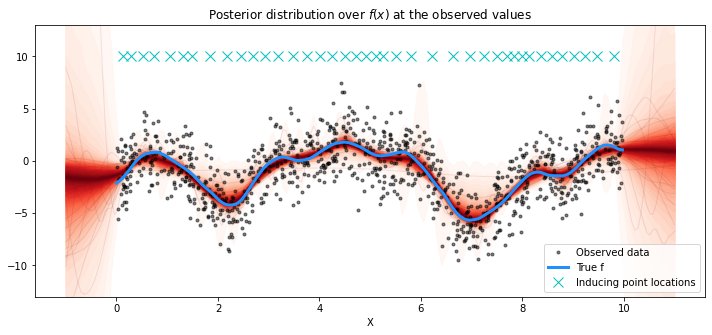

In [31]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

plot_gp_dist(ax,az.extract_dataset(pred_samples.posterior_predictive).f_pred.transpose(), X_new)

# plot the data and the true latent function
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(Xu, 10 * np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X")
plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [70]:
Xu_init = 10 * np.random.rand(20)

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    # set flat prior for Xu
    Xu = pm.Flat("Xu", shape=20, testval=Xu_init)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu[:, None], y=y, noise=σ)

    mp = pm.find_MAP()

/home/anatoly/Projects/Proj_Air_Quality/env/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


/home/anatoly/Projects/Proj_Air_Quality/env/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


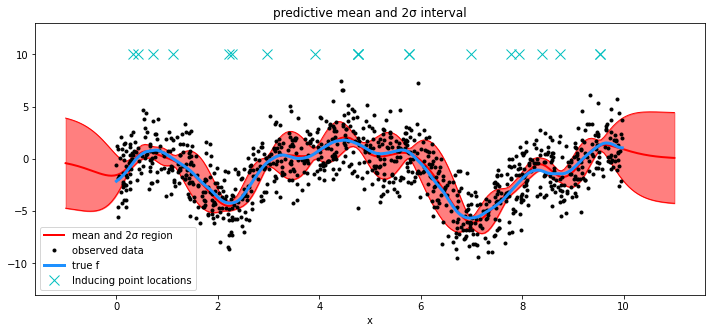

In [71]:
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, "r", lw=2, label="mean and 2σ region")
plt.plot(X_new, mu + 2 * sd, "r", lw=1)
plt.plot(X_new, mu - 2 * sd, "r", lw=1)
plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")
Xu = mp["Xu"]
plt.plot(Xu, 10 * np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("predictive mean and 2σ interval")
plt.legend();